# 序参量分析

本笔记本用于分析不同系统大小（L=4和L=5）下的序参量随J1的变化。

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from itertools import cycle

In [2]:
# 设置结果目录
base_dir = "../results"
print("结果目录：", base_dir)

结果目录： ../results


In [3]:
def parse_analysis_log(log_file):
    """
    解析分析日志文件，提取J1值和三种序参量
    """
    try:
        with open(log_file, 'r') as f:
            content = f.read()
            
        # 提取L, J2, J1值
        params_pattern = r"开始分析量子态: L=(\d+), J2=([\d\.]+), J1=([\d\.]+)"
        params_match = re.search(params_pattern, content)
        if params_match:
            L = int(params_match.group(1))
            J2 = float(params_match.group(2))
            J1 = float(params_match.group(3))
        else:
            # 尝试从文件名提取参数
            filename_pattern = r"analyze_L=(\d+)_J2=([\d\.]+)_J1=([\d\.]+)\.log"
            filename_match = re.search(filename_pattern, os.path.basename(log_file))
            if filename_match:
                L = int(filename_match.group(1))
                J2 = float(filename_match.group(2))
                J1 = float(filename_match.group(3))
            else:
                print(f"无法从文件 {log_file} 中提取参数")
                return None
        
        # 提取序参量
        order_pattern = r"序参量: AF Order=([\d\.]+), Plaquette Order=([\d\.]+), Dimer Order=([\d\.]+)"
        order_match = re.search(order_pattern, content)
        if order_match:
            af_order = float(order_match.group(1))
            plaq_order = float(order_match.group(2))
            dimer_order = float(order_match.group(3))
        else:
            print(f"无法从文件 {log_file} 中提取序参量")
            return None
            
        # 提取相关比率
        ratio_pattern = r"相关比率: Neel=([\d\.]+), Plaquette=([\d\.]+), Dimer=([\d\.]+)"
        ratio_match = re.search(ratio_pattern, content)
        if ratio_match:
            neel_ratio = float(ratio_match.group(1))
            plaq_ratio = float(ratio_match.group(2))
            dimer_ratio = float(ratio_match.group(3))
        else:
            print(f"无法从文件 {log_file} 中提取相关比率")
            neel_ratio = plaq_ratio = dimer_ratio = 0.0
            
        return {
            'L': L,
            'J2': J2,
            'J1': J1,
            'af_order': af_order,
            'plaq_order': plaq_order,
            'dimer_order': dimer_order,
            'neel_ratio': neel_ratio,
            'plaq_ratio': plaq_ratio,
            'dimer_ratio': dimer_ratio
        }
    except Exception as e:
        print(f"解析文件 {log_file} 时出错：{e}")
        return None

In [4]:
def collect_data(base_dir, L_values, J2=0.05):
    """
    收集指定L值和J2值的所有数据
    """
    all_data = []
    
    for L in L_values:
        L_dir = os.path.join(base_dir, f"L={L}", f"J2={J2:.2f}")
        if not os.path.exists(L_dir):
            print(f"目录 {L_dir} 不存在")
            continue
            
        # 遍历所有J1目录
        for J1_dir in os.listdir(L_dir):
            if not J1_dir.startswith("J1="):
                continue
                
            analysis_dir = os.path.join(L_dir, J1_dir, "analysis")
            if not os.path.exists(analysis_dir):
                continue
                
            # 查找分析日志文件
            for file in os.listdir(analysis_dir):
                if file.startswith("analyze_") and file.endswith(".log"):
                    log_file = os.path.join(analysis_dir, file)
                    data = parse_analysis_log(log_file)
                    if data:
                        all_data.append(data)
    
    # 按L和J1排序
    all_data.sort(key=lambda x: (x['L'], x['J1']))
    return all_data

In [5]:
# 收集L=4和L=5的数据
data = collect_data(base_dir, [4, 5], J2=0.05)
print(f"共收集到 {len(data)} 条数据")

# 按L值分组
L4_data = [d for d in data if d['L'] == 4]
L5_data = [d for d in data if d['L'] == 5]

print(f"L=4: {len(L4_data)} 条数据")
print(f"L=5: {len(L5_data)} 条数据")

无法从文件 ../results/L=5/J2=0.05/J1=0.02/analysis/analyze_L=5_J2=0.05_J1=0.02.log 中提取序参量
无法从文件 ../results/L=5/J2=0.05/J1=0.03/analysis/analyze_L=5_J2=0.05_J1=0.03.log 中提取序参量
无法从文件 ../results/L=5/J2=0.05/J1=0.01/analysis/analyze_L=5_J2=0.05_J1=0.01.log 中提取序参量
无法从文件 ../results/L=5/J2=0.05/J1=0.00/analysis/analyze_L=5_J2=0.05_J1=0.00.log 中提取序参量
共收集到 11 条数据
L=4: 11 条数据
L=5: 0 条数据


## 1. L=4 和 L=5 分别序参量 vs J1，三个序参量在同一张图上

In [6]:
def plot_order_parameters_vs_J1(L_data, L, figsize=(10, 6)):
    """
    绘制指定L值的三个序参量随J1的变化
    """
    # 提取数据
    J1_values = [d['J1'] for d in L_data]
    af_values = [d['af_order'] for d in L_data]
    plaq_values = [d['plaq_order'] for d in L_data]
    dimer_values = [d['dimer_order'] for d in L_data]
    
    # 创建图表
    plt.figure(figsize=figsize)
    
    # 绘制三个序参量
    plt.plot(J1_values, af_values, 'o-', label='AF Order', color='red')
    plt.plot(J1_values, plaq_values, 's-', label='Plaquette Order', color='blue')
    plt.plot(J1_values, dimer_values, '^-', label='Dimer Order', color='green')
    
    # 设置图表属性
    plt.xlabel('$J_1$', fontsize=14)
    plt.ylabel('Order Parameter', fontsize=14)
    plt.title(f'Order Parameters vs $J_1$ (L={L}, $J_2=0.05$)', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # 调整x轴范围，确保从0开始
    plt.xlim(0, max(J1_values) * 1.05)
    
    plt.tight_layout()
    return plt.gcf()

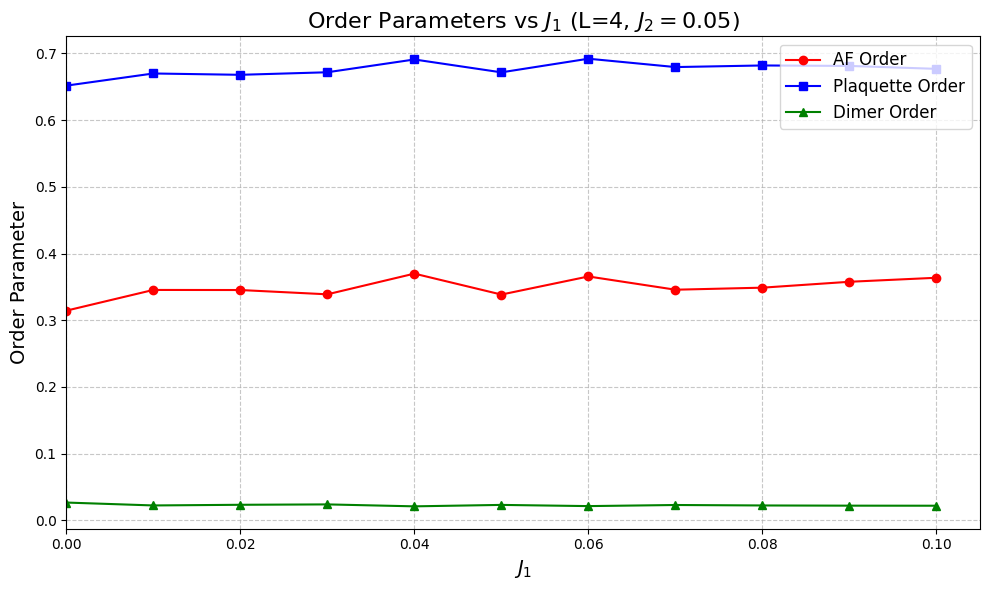

In [7]:
# 绘制L=4的序参量图
fig_L4 = plot_order_parameters_vs_J1(L4_data, 4)
plt.savefig("order_parameters_L4.png", dpi=300)
plt.show()

In [8]:
# 绘制L=5的序参量图
if L5_data:  # 确保有L=5的数据
    fig_L5 = plot_order_parameters_vs_J1(L5_data, 5)
    plt.savefig("order_parameters_L5.png", dpi=300)
    plt.show()
else:
    print("没有L=5的数据可供绘图")

没有L=5的数据可供绘图


## 2. Order Ratio vs J1，L=4或L=5在同一张图上，绘制分别三个序参量

In [9]:
def plot_order_ratio_vs_J1(data, order_type, figsize=(10, 6)):
    """
    绘制指定序参量的相关比率随J1的变化，L=4和L=5在同一张图上
    
    参数:
    - data: 所有数据
    - order_type: 'neel', 'plaq', 或 'dimer'
    """
    # 按L值分组
    L4_data = [d for d in data if d['L'] == 4]
    L5_data = [d for d in data if d['L'] == 5]
    
    # 提取数据
    L4_J1_values = [d['J1'] for d in L4_data]
    L5_J1_values = [d['J1'] for d in L5_data]
    
    if order_type == 'neel':
        L4_ratio_values = [d['neel_ratio'] for d in L4_data]
        L5_ratio_values = [d['neel_ratio'] for d in L5_data]
        title = 'Neel Correlation Ratio vs $J_1$ ($J_2=0.05$)'
        ylabel = 'Neel Correlation Ratio'
        color1, color2 = 'red', 'darkred'
    elif order_type == 'plaq':
        L4_ratio_values = [d['plaq_ratio'] for d in L4_data]
        L5_ratio_values = [d['plaq_ratio'] for d in L5_data]
        title = 'Plaquette Correlation Ratio vs $J_1$ ($J_2=0.05$)'
        ylabel = 'Plaquette Correlation Ratio'
        color1, color2 = 'blue', 'darkblue'
    elif order_type == 'dimer':
        L4_ratio_values = [d['dimer_ratio'] for d in L4_data]
        L5_ratio_values = [d['dimer_ratio'] for d in L5_data]
        title = 'Dimer Correlation Ratio vs $J_1$ ($J_2=0.05$)'
        ylabel = 'Dimer Correlation Ratio'
        color1, color2 = 'green', 'darkgreen'
    else:
        raise ValueError(f"未知的序参量类型: {order_type}")
    
    # 创建图表
    plt.figure(figsize=figsize)
    
    # 绘制L=4和L=5的数据
    plt.plot(L4_J1_values, L4_ratio_values, 'o-', label='L=4', color=color1)
    if L5_data:  # 确保有L=5的数据
        plt.plot(L5_J1_values, L5_ratio_values, 's-', label='L=5', color=color2)
    
    # 设置图表属性
    plt.xlabel('$J_1$', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # 调整x轴范围，确保从0开始
    plt.xlim(0, max(L4_J1_values + L5_J1_values) * 1.05)
    
    plt.tight_layout()
    return plt.gcf()

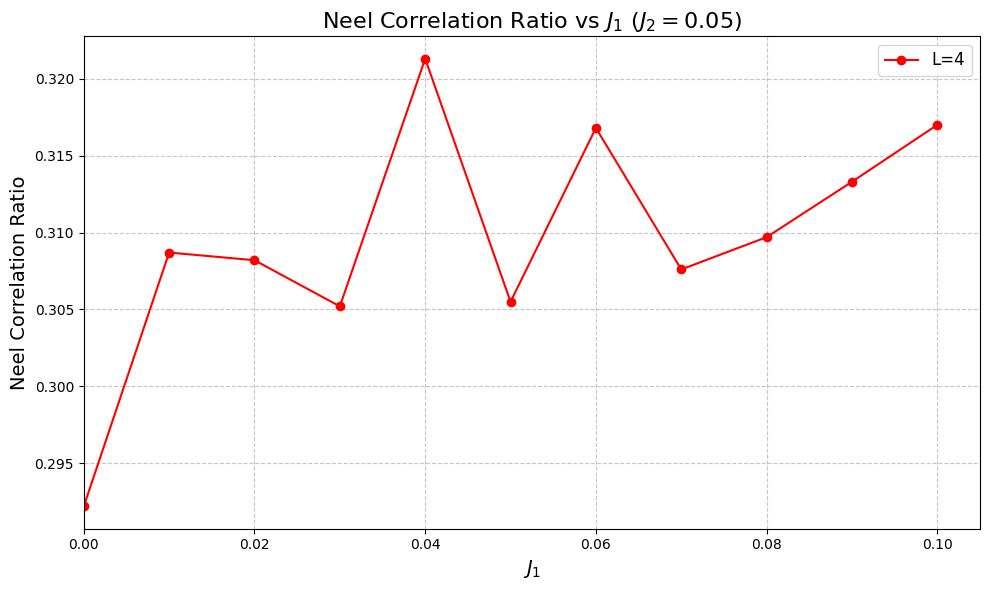

In [10]:
# 绘制Neel相关比率图
fig_neel = plot_order_ratio_vs_J1(data, 'neel')
plt.savefig("neel_ratio_vs_J1.png", dpi=300)
plt.show()

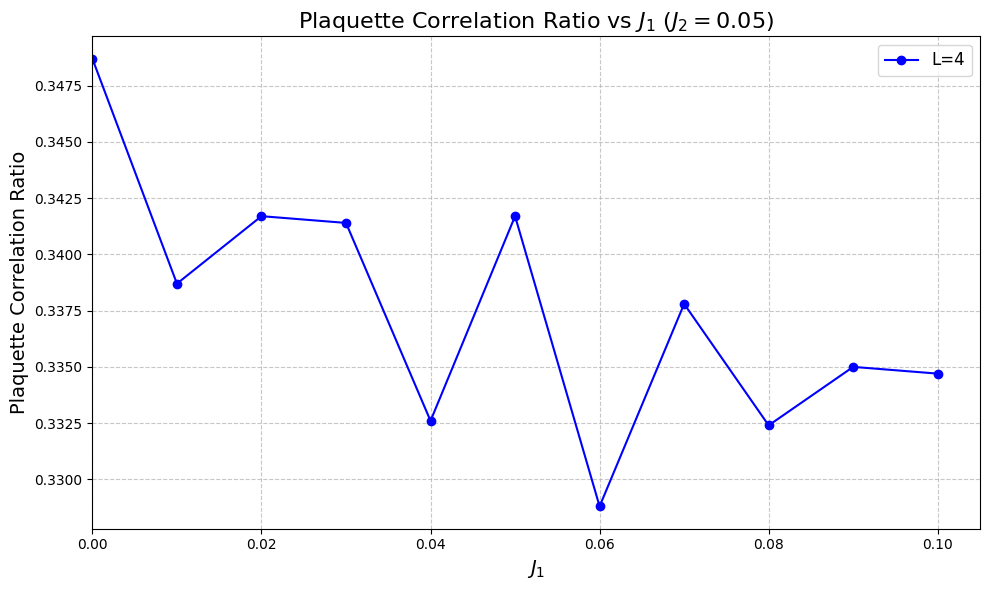

In [11]:
# 绘制Plaquette相关比率图
fig_plaq = plot_order_ratio_vs_J1(data, 'plaq')
plt.savefig("plaquette_ratio_vs_J1.png", dpi=300)
plt.show()

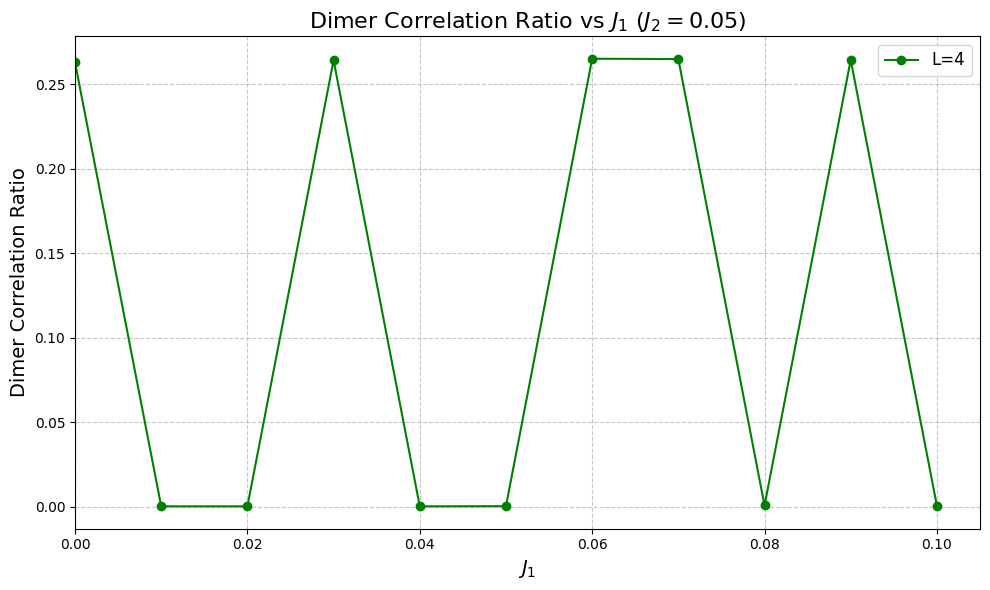

In [12]:
# 绘制Dimer相关比率图
fig_dimer = plot_order_ratio_vs_J1(data, 'dimer')
plt.savefig("dimer_ratio_vs_J1.png", dpi=300)
plt.show()

In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def parse_analysis_log(log_file):
    """
    解析分析日志文件，提取J1值和三种序参量
    """
    try:
        with open(log_file, 'r') as f:
            content = f.read()
            
        # 提取L, J2, J1值
        params_pattern = r"开始分析量子态: L=(\d+), J2=([\d\.]+), J1=([\d\.]+)"
        params_match = re.search(params_pattern, content)
        if params_match:
            L = int(params_match.group(1))
            J2 = float(params_match.group(2))
            J1 = float(params_match.group(3))
        else:
            # 尝试从文件名提取参数
            filename_pattern = r"analyze_L=(\d+)_J2=([\d\.]+)_J1=([\d\.]+)\.log"
            filename_match = re.search(filename_pattern, os.path.basename(log_file))
            if filename_match:
                L = int(filename_match.group(1))
                J2 = float(filename_match.group(2))
                J1 = float(filename_match.group(3))
            else:
                print(f"无法从文件 {log_file} 中提取参数")
                return None
        
        # 提取序参量
        # 首先尝试从总结行提取
        order_pattern = r"序参量: AF Order=([\d\.]+), Plaquette Order=([\d\.]+), Dimer Order=([\d\.]+)"
        order_match = re.search(order_pattern, content)
        if order_match:
            af_order = float(order_match.group(1))
            plaq_order = float(order_match.group(2))
            dimer_order = float(order_match.group(3))
        else:
            # 如果没有总结行，尝试从各个部分提取
            af_pattern = r"反铁磁序参数 m\^2\(L\) = ([\d\.]+)"
            plaq_pattern = r"简盘序参量 m_p\(L\) = ([\d\.]+)"
            dimer_pattern = r"二聚体序参量 D\^2 = ([\d\.]+)"
            
            af_match = re.search(af_pattern, content)
            plaq_match = re.search(plaq_pattern, content)
            dimer_match = re.search(dimer_pattern, content)
            
            if af_match:
                af_order = float(af_match.group(1))
            else:
                print(f"无法从文件 {log_file} 中提取反铁磁序参量")
                af_order = 0.0
                
            if plaq_match:
                plaq_order = float(plaq_match.group(1))
            else:
                print(f"无法从文件 {log_file} 中提取简盘序参量")
                plaq_order = 0.0
                
            if dimer_match:
                dimer_order = float(dimer_match.group(1))
            else:
                print(f"无法从文件 {log_file} 中提取二聚体序参量")
                dimer_order = 0.0
                
            if not (af_match or plaq_match or dimer_match):
                print(f"无法从文件 {log_file} 中提取任何序参量")
                return None
            
        # 提取相关比率
        # 首先尝试从总结行提取
        ratio_pattern = r"相关比率: Neel=([\d\.]+), Plaquette=([\d\.]+), Dimer=([\d\.]+)"
        ratio_match = re.search(ratio_pattern, content)
        if ratio_match:
            neel_ratio = float(ratio_match.group(1))
            plaq_ratio = float(ratio_match.group(2))
            dimer_ratio = float(ratio_match.group(3))
        else:
            # 如果没有总结行，尝试从各个部分提取
            neel_ratio_pattern = r"Neel 相关比率: ([\d\.]+)"
            plaq_ratio_pattern = r"Plaquette 相关比率: ([\d\.]+)"
            dimer_ratio_pattern = r"Dimer 相关比率: ([\d\.]+)"
            
            neel_ratio_match = re.search(neel_ratio_pattern, content)
            plaq_ratio_match = re.search(plaq_ratio_pattern, content)
            dimer_ratio_match = re.search(dimer_ratio_pattern, content)
            
            if neel_ratio_match:
                neel_ratio = float(neel_ratio_match.group(1))
            else:
                print(f"无法从文件 {log_file} 中提取Neel相关比率")
                neel_ratio = 0.0
                
            if plaq_ratio_match:
                plaq_ratio = float(plaq_ratio_match.group(1))
            else:
                print(f"无法从文件 {log_file} 中提取Plaquette相关比率")
                plaq_ratio = 0.0
                
            if dimer_ratio_match:
                dimer_ratio = float(dimer_ratio_match.group(1))
            else:
                print(f"无法从文件 {log_file} 中提取Dimer相关比率")
                dimer_ratio = 0.0
            
        # 打印提取的数据，用于调试
        print(f"从文件 {os.path.basename(log_file)} 中提取的数据:")
        print(f"  L={L}, J2={J2:.2f}, J1={J1:.2f}")
        print(f"  序参量: AF={af_order:.6f}, Plaquette={plaq_order:.6f}, Dimer={dimer_order:.6f}")
        print(f"  相关比率: Neel={neel_ratio:.4f}, Plaquette={plaq_ratio:.4f}, Dimer={dimer_ratio:.4f}")
            
        return {
            'L': L,
            'J2': J2,
            'J1': J1,
            'af_order': af_order,
            'plaq_order': plaq_order,
            'dimer_order': dimer_order,
            'neel_ratio': neel_ratio,
            'plaq_ratio': plaq_ratio,
            'dimer_ratio': dimer_ratio
        }
    except Exception as e:
        print(f"解析文件 {log_file} 时出错：{e}")
        return None

def collect_data(base_dir, L_values, J2=0.05):
    """
    收集指定L值和J2值的所有数据
    """
    all_data = []
    
    for L in L_values:
        L_dir = os.path.join(base_dir, f"L={L}", f"J2={J2:.2f}")
        if not os.path.exists(L_dir):
            print(f"目录 {L_dir} 不存在")
            continue
            
        # 遍历所有J1目录
        for J1_dir in os.listdir(L_dir):
            if not J1_dir.startswith("J1="):
                continue
                
            analysis_dir = os.path.join(L_dir, J1_dir, "analysis")
            if not os.path.exists(analysis_dir):
                continue
                
            # 查找分析日志文件
            for file in os.listdir(analysis_dir):
                if file.startswith("analyze_") and file.endswith(".log"):
                    log_file = os.path.join(analysis_dir, file)
                    data = parse_analysis_log(log_file)
                    if data:
                        all_data.append(data)
    
    # 按L和J1排序
    all_data.sort(key=lambda x: (x['L'], x['J1']))
    return all_data

def plot_order_parameters_vs_J1(L_data, L, figsize=(10, 6)):
    """
    绘制指定L值的三个序参量随J1的变化
    """
    # 提取数据
    J1_values = [d['J1'] for d in L_data]
    af_values = [d['af_order'] for d in L_data]
    plaq_values = [d['plaq_order'] for d in L_data]
    dimer_values = [d['dimer_order'] for d in L_data]
    
    # 创建图表
    plt.figure(figsize=figsize)
    
    # 绘制三个序参量
    plt.plot(J1_values, af_values, 'o-', label='AF Order', color='red')
    plt.plot(J1_values, plaq_values, 's-', label='Plaquette Order', color='blue')
    plt.plot(J1_values, dimer_values, '^-', label='Dimer Order', color='green')
    
    # 设置图表属性
    plt.xlabel('$J_1$', fontsize=14)
    plt.ylabel('Order Parameter', fontsize=14)
    plt.title(f'Order Parameters vs $J_1$ (L={L}, $J_2=0.05$)', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # 调整x轴范围，确保从0开始
    plt.xlim(0, max(J1_values) * 1.05)
    
    plt.tight_layout()
    return plt.gcf()

def plot_order_ratio_vs_J1(data, order_type, figsize=(10, 6)):
    """
    绘制指定序参量的相关比率随J1的变化，L=4和L=5在同一张图上
    
    参数:
    - data: 所有数据
    - order_type: 'neel', 'plaq', 或 'dimer'
    """
    # 按L值分组
    L4_data = [d for d in data if d['L'] == 4]
    L5_data = [d for d in data if d['L'] == 5]
    
    # 提取数据
    L4_J1_values = [d['J1'] for d in L4_data]
    L5_J1_values = [d['J1'] for d in L5_data]
    
    if order_type == 'neel':
        L4_ratio_values = [d['neel_ratio'] for d in L4_data]
        L5_ratio_values = [d['neel_ratio'] for d in L5_data]
        title = 'Neel Correlation Ratio vs $J_1$ ($J_2=0.05$)'
        ylabel = 'Neel Correlation Ratio'
        color1, color2 = 'red', 'darkred'
    elif order_type == 'plaq':
        L4_ratio_values = [d['plaq_ratio'] for d in L4_data]
        L5_ratio_values = [d['plaq_ratio'] for d in L5_data]
        title = 'Plaquette Correlation Ratio vs $J_1$ ($J_2=0.05$)'
        ylabel = 'Plaquette Correlation Ratio'
        color1, color2 = 'blue', 'darkblue'
    elif order_type == 'dimer':
        L4_ratio_values = [d['dimer_ratio'] for d in L4_data]
        L5_ratio_values = [d['dimer_ratio'] for d in L5_data]
        title = 'Dimer Correlation Ratio vs $J_1$ ($J_2=0.05$)'
        ylabel = 'Dimer Correlation Ratio'
        color1, color2 = 'green', 'darkgreen'
    else:
        raise ValueError(f"未知的序参量类型: {order_type}")
    
    # 创建图表
    plt.figure(figsize=figsize)
    
    # 绘制L=4和L=5的数据
    plt.plot(L4_J1_values, L4_ratio_values, 'o-', label='L=4', color=color1)
    if L5_data:  # 确保有L=5的数据
        plt.plot(L5_J1_values, L5_ratio_values, 's-', label='L=5', color=color2)
    
    # 设置图表属性
    plt.xlabel('$J_1$', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # 调整x轴范围，确保从0开始
    max_J1 = max(L4_J1_values + (L5_J1_values if L5_data else [0]))
    plt.xlim(0, max_J1 * 1.05)
    
    plt.tight_layout()
    return plt.gcf()

def main():
    # 设置结果目录
    base_dir = "../results"
    print("结果目录：", base_dir)
    
    # 收集L=4和L=5的数据
    data = collect_data(base_dir, [4, 5], J2=0.05)
    print(f"共收集到 {len(data)} 条数据")
    
    # 按L值分组
    L4_data = [d for d in data if d['L'] == 4]
    L5_data = [d for d in data if d['L'] == 5]
    
    print(f"L=4: {len(L4_data)} 条数据")
    print(f"L=5: {len(L5_data)} 条数据")
    
    # 绘制L=4的序参量图
    fig_L4 = plot_order_parameters_vs_J1(L4_data, 4)
    plt.savefig("order_parameters_L4.png", dpi=300)
    plt.close()
    
    # 绘制L=5的序参量图
    if L5_data:  # 确保有L=5的数据
        fig_L5 = plot_order_parameters_vs_J1(L5_data, 5)
        plt.savefig("order_parameters_L5.png", dpi=300)
        plt.close()
    else:
        print("没有L=5的数据可供绘图")
    
    # 绘制Neel相关比率图
    fig_neel = plot_order_ratio_vs_J1(data, 'neel')
    plt.savefig("neel_ratio_vs_J1.png", dpi=300)
    plt.close()
    
    # 绘制Plaquette相关比率图
    fig_plaq = plot_order_ratio_vs_J1(data, 'plaq')
    plt.savefig("plaquette_ratio_vs_J1.png", dpi=300)
    plt.close()
    
    # 绘制Dimer相关比率图
    fig_dimer = plot_order_ratio_vs_J1(data, 'dimer')
    plt.savefig("dimer_ratio_vs_J1.png", dpi=300)
    plt.close()
    
    print("所有图表已保存")

if __name__ == "__main__":
    main()


结果目录： ../results
从文件 analyze_L=4_J2=0.05_J1=0.10.log 中提取的数据:
  L=4, J2=0.05, J1=0.10
  序参量: AF=0.363674, Plaquette=0.676743, Dimer=0.022036
  相关比率: Neel=0.3170, Plaquette=0.3347, Dimer=0.0004
从文件 analyze_L=4_J2=0.05_J1=0.05.log 中提取的数据:
  L=4, J2=0.05, J1=0.05
  序参量: AF=0.338492, Plaquette=0.671515, Dimer=0.023259
  相关比率: Neel=0.3055, Plaquette=0.3417, Dimer=0.0002
从文件 analyze_L=4_J2=0.05_J1=0.02.log 中提取的数据:
  L=4, J2=0.05, J1=0.02
  序参量: AF=0.345287, Plaquette=0.667830, Dimer=0.023435
  相关比率: Neel=0.3082, Plaquette=0.3417, Dimer=0.0001
从文件 analyze_L=4_J2=0.05_J1=0.03.log 中提取的数据:
  L=4, J2=0.05, J1=0.03
  序参量: AF=0.338860, Plaquette=0.671637, Dimer=0.024008
  相关比率: Neel=0.3052, Plaquette=0.3414, Dimer=0.2642
从文件 analyze_L=4_J2=0.05_J1=0.04.log 中提取的数据:
  L=4, J2=0.05, J1=0.04
  序参量: AF=0.369873, Plaquette=0.690803, Dimer=0.021105
  相关比率: Neel=0.3213, Plaquette=0.3326, Dimer=0.0001
从文件 analyze_L=4_J2=0.05_J1=0.01.log 中提取的数据:
  L=4, J2=0.05, J1=0.01
  序参量: AF=0.345414, Plaquette=0.669816, 